In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS

from pyinterpolate.semivariance import calculate_semivariance
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import Krige

# Read Point Measurements and Canvas

In [2]:
readings = pd.read_csv('pm25_year_2021_daily.csv', index_col='name')
canvas = gpd.read_file('hexgrid.shp')
canvas['points'] = canvas.centroid

In [3]:
readings.head()

,01.01.2021,02.01.2021,03.01.2021,04.01.2021,05.01.2021,06.01.2021,07.01.2021,08.01.2021,09.01.2021,10.01.2021,...,24.05.2021,25.05.2021,26.05.2021,27.05.2021,28.05.2021,29.05.2021,30.05.2021,31.05.2021,x,y
name,,,,,,,,,,,,,,,,,,,,,
Legnica - Polarna,42.8,55.2,41.9,43.6,17.2,14.5,13.0,22.3,19.5,19.6,...,6.8,5.4,6.1,5.4,5.3,4.6,4.5,3.9,4.752551e+06,3.140166e+06
Osieczów,32.7,27.7,28.4,26.3,11.7,4.8,8.7,13.9,9.8,12.8,...,7.0,5.8,4.8,4.6,5.7,4.3,5.6,5.3,4.699284e+06,3.148150e+06
Wałbrzych - Wysockiego,23.6,54.3,66.3,64.5,11.1,18.4,18.3,17.6,23.1,27.4,...,9.0,5.9,6.2,7.3,5.2,4.9,4.6,4.8,4.762693e+06,3.091949e+06
Wrocław - Na Grobli,28.9,48.1,54.0,57.6,18.9,21.8,17.4,20.9,17.8,17.1,...,6.9,5.5,3.9,4.9,5.4,3.5,3.1,2.6,4.814559e+06,3.134107e+06
Zgorzelec - Bohaterów Getta,34.6,35.9,38.2,34.7,17.5,11.1,15.5,21.8,15.4,18.4,...,10.6,15.4,9.2,8.5,11.1,5.7,8.7,5.6,4.671112e+06,3.127473e+06


In [4]:
canvas.head()

,id,geometry,points
0,1265.0,"POLYGON ((5262483.451 3241159.737, 5262533.545...",POINT (5264567.424 3235499.996)
1,1267.0,"POLYGON ((5266784.217 3208609.593, 5278331.223...",POINT (5272557.720 3198609.593)
2,1266.0,"MULTIPOLYGON (((5267077.091 3228607.316, 52670...",POINT (5268791.749 3214872.652)
3,1269.0,"POLYGON ((5266784.217 3168609.593, 5278331.223...",POINT (5272557.720 3158609.593)
4,1268.0,"POLYGON ((5266784.217 3188609.593, 5278331.223...",POINT (5272557.720 3178609.593)


In [5]:
# Take one reading and x, y columns

In [6]:
df = readings[['01.01.2021', 'x', 'y']]
df.columns = ['pm2.5', 'x', 'y']

In [7]:
df.head()

,pm2.5,x,y
name,,,
Legnica - Polarna,42.8,4.752551e+06,3.140166e+06
Osieczów,32.7,4.699284e+06,3.148150e+06
Wałbrzych - Wysockiego,23.6,4.762693e+06,3.091949e+06
Wrocław - Na Grobli,28.9,4.814559e+06,3.134107e+06
Zgorzelec - Bohaterów Getta,34.6,4.671112e+06,3.127473e+06


# Transform `DataFrame` into `GeoDataFrame`

In [8]:
DATA_CRS = CRS.from_epsg('2180')

In [9]:
DATA_CRS

<Projected CRS: EPSG:2180>
Name: ETRF2000-PL / CS92
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore.
- bounds: (14.14, 49.0, 24.15, 55.93)
Coordinate Operation:
- name: Poland CS92
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
df['geometry'] = gpd.points_from_xy(df['x'], df['y'])

/home/szymon/miniconda3/envs/pyintpk/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=DATA_CRS)

In [12]:
# Remove NaNs

gdf = gdf.dropna()

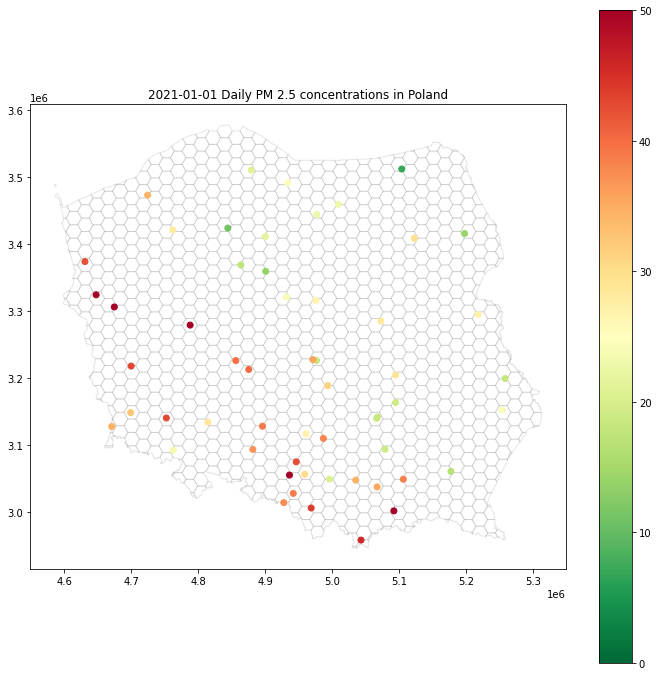

In [13]:
base = canvas.plot(color='white', edgecolor='black', alpha=0.1, figsize=(12, 12))
gdf.plot(ax=base, column='pm2.5', legend=True, vmin=0, vmax=50, cmap='RdYlGn_r')
base.set_title('2021-01-01 Daily PM 2.5 concentrations in Poland');

# Build Variogram Model

In [14]:
km_c = 10**3  # 1 km is 1000 m 
STEP_SIZE = km_c * 30  # 30 km
MAX_RANGE = km_c * 300  # 300 km

In [20]:
arr = gdf[['x', 'y', 'pm2.5']].values

semivar = calculate_semivariance(arr,
                                 step_size=STEP_SIZE,
                                 max_range=MAX_RANGE)

In [21]:
semivar

array([[0.00000000e+00, 5.05416667e+00, 6.00000000e+01],
       [3.00000000e+04, 5.76951786e+01, 5.60000000e+01],
       [6.00000000e+04, 9.47646939e+01, 9.80000000e+01],
       [9.00000000e+04, 7.46993333e+01, 1.50000000e+02],
       [1.20000000e+05, 7.45332632e+01, 1.90000000e+02],
       [1.50000000e+05, 1.31586140e+02, 2.28000000e+02],
       [1.80000000e+05, 1.24392830e+02, 2.12000000e+02],
       [2.10000000e+05, 1.40270976e+02, 2.46000000e+02],
       [2.40000000e+05, 1.41650229e+02, 2.18000000e+02],
       [2.70000000e+05, 1.42644732e+02, 2.24000000e+02]])

Model: spherical, error value: 14.883011196460364
Model: exponential, error value: 11.923251044562488
Model: linear, error value: 16.2620822478926
Model: cubic, error value: 18.475459160607407
Model: circular, error value: 15.055262629461069
Model: power, error value: 22.93606545054868
Chosen model: exponential, with value: 11.923251044562488.


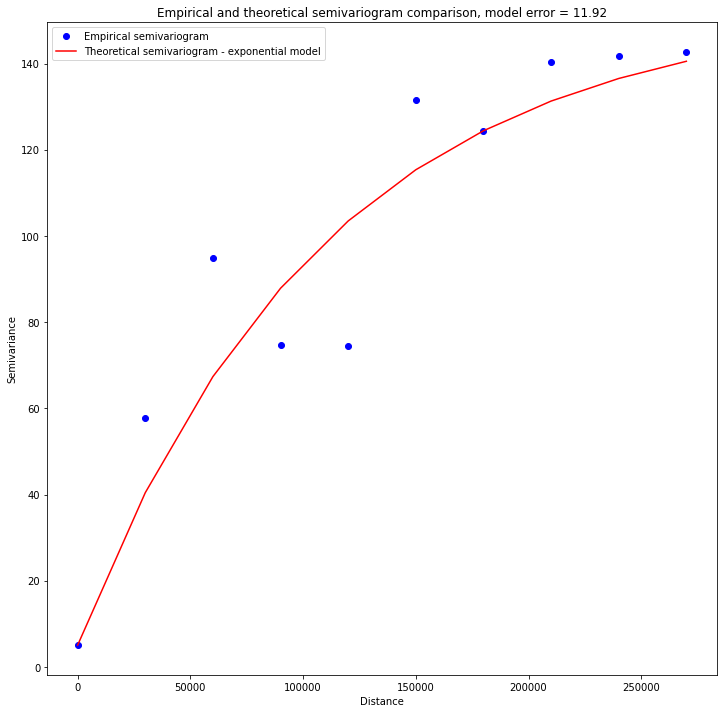

In [16]:
ts = TheoreticalSemivariogram(points_array=arr, empirical_semivariance=semivar, verbose=True)
ts.find_optimal_model()
ts.show_semivariogram()

# Interpolate Missing Values with Kriging

In [17]:
pk = Krige(ts, arr)

In [18]:
def get_prediction(upts, mdl, nn=8):
    pt = [upts.x, upts.y]
    predicted = mdl.ordinary_kriging(pt, nn)
    return pd.Series([upts, predicted[0], predicted[1]])

# Predict
    
predicted = canvas['points'].apply(get_prediction, mdl=pk)
predicted.columns = ['coordinates', 'yhat', 'error']
    
# Merge with canvas
    
cdf = canvas.join(predicted)
cdf = cdf[['geometry', 'yhat', 'error']]

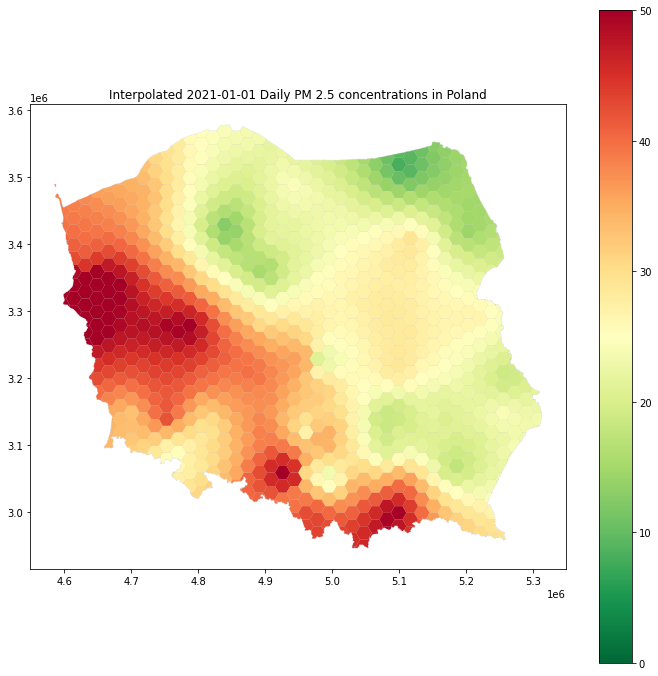

In [19]:
base = canvas.plot(color='white', edgecolor='black', alpha=0.1, figsize=(12, 12))
cdf.plot(ax=base, column='yhat', legend=True, vmin=0, vmax=50, cmap='RdYlGn_r')
base.set_title('Interpolated 2021-01-01 Daily PM 2.5 concentrations in Poland');

---